0. データ前処理、csv生成（ボラティリティなど）

In [12]:
# 0. データ前処理・特徴量生成

import os, re, warnings
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", category=FutureWarning)

# ====== 入出力パス ======
RAW_CSV_PATH = os.path.join("", "Dataset_Simulated_Price_swaption.csv")
OUT_DIR       = os.path.join("", "data")
os.makedirs(OUT_DIR, exist_ok=True)
FEATURES_CSV  = os.path.join(OUT_DIR, "swaption_features.csv")

# ====== ターゲット近傍の座標（任意に変更可） ======
TARGET_TENOR    = 5.0
TARGET_MATURITY = 1.0/12.0  # 0.0833333...

def _parse_grid_columns(cols):
    """ 'Tenor : x; Maturity : y' → (tenor, maturity) の MultiIndex """
    grid_pairs = []
    keep_cols  = []
    for c in cols:
        if c.strip().lower() == "date":
            continue
        m = re.search(r"Tenor\s*:\s*([0-9\.Ee\-\+]+)\s*;\s*Maturity\s*:\s*([0-9\.Ee\-\+]+)", str(c))
        if m:
            t = float(m.group(1))
            u = float(m.group(2))
            grid_pairs.append((t, u))
            keep_cols.append(c)
    return keep_cols, pd.MultiIndex.from_tuples(grid_pairs, names=["Tenor","Maturity"])

def _rolling_realized_measures(ret, win=22):
    """RV, RQ (quarticity), BPV（ジャンプに頑健な双乗変動）"""
    # 安定化のため極小値をクリップ
    r2 = ret**2
    rv = r2.rolling(win).sum().pow(0.5)
    rq = (ret**4).rolling(win).sum()
    bpv = (ret.abs() * ret.shift(1).abs()).rolling(win).sum()
    return rv, rq, bpv

def _nearest_index(values, x):
    values = np.asarray(values)
    return int(np.argmin(np.abs(values - x)))

# ====== 読み込み ======
print("[0] CSV 読み込み:", RAW_CSV_PATH)
df_raw = pd.read_csv(RAW_CSV_PATH)
date_col = [c for c in df_raw.columns if str(c).strip().lower()=="date"]
assert len(date_col)==1, "Date 列が見つかりません。"
df_raw["Date"] = pd.to_datetime(df_raw[date_col[0]], errors="coerce")
df_raw = df_raw.dropna(subset=["Date"]).reset_index(drop=True)

grid_cols_raw = [c for c in df_raw.columns if c!="Date"]
keep_cols, grid_mi = _parse_grid_columns(grid_cols_raw)
grid_wide = df_raw[keep_cols].copy()
grid_wide.columns = grid_mi
grid_wide.index = df_raw["Date"]

# ソートされた MultiIndex（Tenor, Maturity）
grid_wide = grid_wide.sort_index(axis=1)

# ====== ターゲット系列の決定 ======
tenors    = np.array(sorted(list(set([i[0] for i in grid_wide.columns]))))
maturitys = np.array(sorted(list(set([i[1] for i in grid_wide.columns]))))

ti = _nearest_index(tenors, TARGET_TENOR)
mi = _nearest_index(maturitys, TARGET_MATURITY)

target_key = (tenors[ti], maturitys[mi])
print(f"[0] ターゲット近傍: (Tenor, Maturity) = {target_key}")

target_ser = grid_wide[(tenors[ti], maturitys[mi])].copy()

# ====== リターン行列 ======
# 正規化済みの可能性があるが、一般性のため対数差分を用いる
eps = 1e-12
grid_pos = grid_wide.clip(lower=eps)
ret_wide = np.log(grid_pos).diff()   # (日次差分想定)

# ====== 実現量（RV/RQ/BPV）など：ターゲット & 全面要約 ======
rv22_t, rq22_t, bpv22_t = _rolling_realized_measures(ret_wide[(tenors[ti], maturitys[mi])], win=22)

# クロスセクション要約
xsec_mean = grid_wide.mean(axis=1)
xsec_std  = grid_wide.std(axis=1)

# ====== PCA（PC1–3）======
# 標準化 → PCA（列：格子点）→ 時系列スコア
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(grid_wide.values)   # shape (T, G)
pca = PCA(n_components=3, random_state=42)
PC = pca.fit_transform(X)
pc1, pc2, pc3 = [pd.Series(PC[:,k], index=grid_wide.index) for k in range(3)]

# ====== 局所勾配（Tenor / Maturity 方向）======
def _local_slope(df_wide, ti, mi):
    # 周辺の差分で中央差分近似
    cols = df_wide.columns
    tenors = sorted(list(set([a for a,b in cols])))
    mats   = sorted(list(set([b for a,b in cols])))
    T = df_wide.index

    # tenor 方向
    t_im1 = tenors[max(ti-1,0)]
    t_ip1 = tenors[min(ti+1,len(tenors)-1)]
    m0    = mats[mi]
    s_ten = (df_wide[(t_ip1,m0)] - df_wide[(t_im1,m0)]) / (t_ip1 - t_im1 if t_ip1!=t_im1 else np.nan)

    # maturity 方向
    m_im1 = mats[max(mi-1,0)]
    m_ip1 = mats[min(mi+1,len(mats)-1)]
    t0    = tenors[ti]
    s_mat = (df_wide[(t0,m_ip1)] - df_wide[(t0,m_im1)]) / (m_ip1 - m_im1 if m_ip1!=m_im1 else np.nan)

    return s_ten, s_mat

slope_ten, slope_mat = _local_slope(grid_wide, ti, mi)

# ====== ターゲットの短期テクニカル補助（軽量）=====
ret_tgt = np.log(target_ser.clip(lower=eps)).diff()
absr_1  = ret_tgt.abs()
absr_5  = ret_tgt.abs().rolling(5).mean()

# ====== 特徴量テーブル ======
families_df = pd.DataFrame({
    "TARGET": target_ser,
    "PC1": pc1, "PC2": pc2, "PC3": pc3,
    "CrossSecMean": xsec_mean,
    "CrossSecStd":  xsec_std,
    "SlopeTenor": slope_ten,
    "SlopeMaturity": slope_mat,
    "RV22": rv22_t,
    "RQ22": rq22_t,
    "BPV22": bpv22_t,
    "AbsR_1": absr_1,
    "AbsR_5": absr_5
}).dropna()

families_df.to_csv(FEATURES_CSV, index=True)
print("[0] 特徴量CSVを保存:", FEATURES_CSV)
print("[0] 形状:", families_df.shape)


[0] CSV 読み込み: Dataset_Simulated_Price_swaption.csv
[0] ターゲット近傍: (Tenor, Maturity) = (np.float64(5.0), np.float64(0.0833333333333333))
[0] 特徴量CSVを保存: data\swaption_features.csv
[0] 形状: (477, 13)


1. 関数定義

In [23]:
# 1. 関数定義群（QR1/QR2 + FS + Baselines + 指標 + DM/MCS）
#   - HAR の推定は Tikhonov（Ridge）で安定化 → SVD not converge を回避
#   - 前向き選択は trial_cols ごとにスケーラを fit → 次元不一致を回避
#   - QR の進化行列はキャッシュして高速化

import time
import numpy as np
import pandas as pd
import scipy.linalg as la
from dataclasses import dataclass
import numpy.linalg as npl

# --------------------------- Logging ---------------------------------
def log(msg, level=0):
    indent = "    " * level
    print(f"{indent}{msg}")

# ---------------------- スケーラ（[-π, π]） --------------------------
def to_minuspi_pi_scaler(X_fit: np.ndarray):
    xmin = X_fit.min(axis=0)
    xmax = X_fit.max(axis=0)
    span = np.where((xmax - xmin) < 1e-12, 1.0, xmax - xmin)
    def transform(X):
        Z = (X - xmin) / span
        Z = np.clip(Z, 0.0, 1.0)
        return (Z * 2.0 - 1.0) * np.pi
    return transform

# ------------------ ラグ系列（デフォルト 3 ラグ） ---------------------
def build_lagged_sequences(df: pd.DataFrame, cols, scaler, idx_arr, n_lags=3):
    X_all = df[cols].values.astype(float)
    X_scaled = scaler(X_all)
    seqs = []
    for t in idx_arr:
        if t < n_lags:
            continue
        seq = []
        for lag in range(1, n_lags+1):
            seq.append(X_scaled[t-lag, :])
        seqs.append(seq)
    return seqs

# -------------- 単一量子ビット RY を状態ベクトルへ適用 ---------------
def apply_ry_inplace(psi: np.ndarray, theta: float, qubit: int, n_total: int):
    c = np.cos(theta/2.0); s = np.sin(theta/2.0)
    step = 1 << qubit
    period = step << 1
    for base in range(0, psi.size, period):
        for off in range(step):
            i0 = base + off
            i1 = i0 + step
            a0 = psi[i0]
            a1 = psi[i1]
            psi[i0] = c*a0 - s*a1
            psi[i1] = s*a0 + c*a1

def expect_Z_all(psi: np.ndarray, n_total: int):
    exps = np.zeros(n_total, dtype=float)
    N = psi.size
    for j in range(n_total):
        step = 1 << j
        period = step << 1
        ssum = 0.0
        for base in range(0, N, period):
            block0 = psi[base:base+step]           # bit j = 0
            block1 = psi[base+step:base+period]    # bit j = 1
            ssum += (np.abs(block0)**2).sum() - (np.abs(block1)**2).sum()
        exps[j] = ssum.real
    return exps

# ------------------- Pauli / Hamiltonian 構築 ------------------------
def kron_n(ops):
    M = ops[0]
    for op in ops[1:]:
        M = np.kron(M, op)
    return M

def pauli(op):
    if op == 'I': return np.eye(2, dtype=complex)
    if op == 'X': return np.array([[0,1],[1,0]], dtype=complex)
    if op == 'Z': return np.array([[1,0],[0,-1]], dtype=complex)
    raise ValueError

def op_single(n, which, qubit):
    ops = [pauli('I')]*n
    ops[qubit] = pauli(which)
    return kron_n(ops)

def op_two_body(n, which1, i, which2, j):
    ops = [pauli('I')]*n
    ops[i] = pauli(which1)
    ops[j] = pauli(which2)
    return kron_n(ops)

@dataclass
class QRCConfig:
    n_total: int
    n_input: int
    tau: float = 1.0
    field_v: float = 1.0
    seed: int = 42
    mode: str = "QR2"    # "QR1" or "QR2"

class QuantumReservoir:
    """
    QR1/QR2：
      - 3ラグを順次 RY で符号化
      - U(τ) と U(τ/2) の2タイムスライス（QR2）
      - Z 期待値を読み出して線形リッジで学習
    → H, U(τ), U(τ/2) はキャッシュして高速化
    """
    _cache = {}

    def __init__(self, cfg: QRCConfig):
        self.cfg = cfg
        key = (cfg.n_total, cfg.tau, cfg.field_v, cfg.seed)
        if key in QuantumReservoir._cache:
            self.H, self.U_tau, self.U_tau2 = QuantumReservoir._cache[key]
        else:
            np.random.seed(cfg.seed)
            n = cfg.n_total
            dim = 1 << n
            J = np.triu(np.random.rand(n, n), 1)  # 結合
            H = np.zeros((dim, dim), dtype=complex)
            for i in range(n):
                H += cfg.field_v * op_single(n, 'Z', i)
            for i in range(n):
                for j in range(i+1, n):
                    if J[i,j] != 0.0:
                        H += J[i,j] * op_two_body(n, 'X', i, 'X', j)
            U_tau  = la.expm(-1j * cfg.tau    * H)
            U_tau2 = la.expm(-1j * (cfg.tau/2)* H)
            QuantumReservoir._cache[key] = (H, U_tau, U_tau2)
            self.H, self.U_tau, self.U_tau2 = H, U_tau, U_tau2

        self.W = None
        self.b = 0.0
        self.in_qubits = list(range(cfg.n_input))
        self.n_total = cfg.n_total

    def _forward_features(self, x_seq):
        n = self.n_total
        dim = 1 << n
        psi = np.zeros(dim, dtype=complex); psi[0] = 1.0
        # 1,2 ステップ
        for step in range(2):
            x = x_seq[2-step]  # x_{t-3} -> x_{t-2}
            for q, th in zip(self.in_qubits, x):
                apply_ry_inplace(psi, th, q, n)
            psi = self.U_tau @ psi
        # 3 ステップ（最後）
        x = x_seq[0]  # x_{t-1}
        for q, th in zip(self.in_qubits, x):
            apply_ry_inplace(psi, th, q, n)
        psi_tau  = self.U_tau  @ psi
        feat_tau = expect_Z_all(psi_tau, n)
        if self.cfg.mode.upper() == "QR2":
            psi_tau2  = self.U_tau2 @ psi
            feat_tau2 = expect_Z_all(psi_tau2, n)
            feat = np.concatenate([feat_tau, feat_tau2], axis=0)
        else:
            feat = feat_tau
        return feat.astype(float)

    def fit(self, X_seq_list, y, ridge=1e-8):
        M = np.array([self._forward_features(seq) for seq in X_seq_list])
        M1 = np.hstack([M, np.ones((M.shape[0],1))])
        A  = M1.T @ M1 + ridge * np.eye(M1.shape[1])
        w  = la.solve(A, M1.T @ y)
        self.W = w[:-1]; self.b = w[-1]

    def predict(self, X_seq_list):
        M = np.array([self._forward_features(seq) for seq in X_seq_list])
        return M @ self.W + self.b

# ------------------ 前向き選択（軽量） -------------------------------
def forward_select_light(df: pd.DataFrame, base_cols, y, initial_train=350, holdout=30,
                         n_total=8, tau=1.0, mode="QR2", max_features=4, seed=42):
    """
    core（initial_train-holdout）でfit → holdoutでMSE評価し 1 変数ずつ採択
    ※ trial_cols ごとにスケーラを fit（列次元の不一致を回避）
    """
    core_end = initial_train - holdout
    idx_core = np.arange(3, core_end)
    idx_hold = np.arange(core_end, initial_train)
    sel, remain = [], base_cols.copy()
    best_tau = tau

    for step in range(max_features):
        t0 = time.time()
        log(f"[FS] step {step+1}/{max_features}: candidates={len(remain)}", 1)
        best, best_mse = None, np.inf

        for c in remain:
            cols = sel + [c]
            scaler = to_minuspi_pi_scaler(df.iloc[:core_end][cols].values.astype(float))
            # 学習
            X_core = build_lagged_sequences(df, cols, scaler, idx_core)
            y_core = y.iloc[3:core_end].values
            cfg = QRCConfig(n_total=n_total, n_input=len(cols), tau=tau, field_v=1.0, seed=seed, mode=mode)
            qrc = QuantumReservoir(cfg); qrc.fit(X_core, y_core)
            # 検証
            X_val = build_lagged_sequences(df, cols, scaler, idx_hold)
            y_val = y.iloc[3+len(idx_core):3+len(idx_core)+len(idx_hold)].values
            yhat  = qrc.predict(X_val)
            mse   = np.mean((y_val - yhat)**2)
            if mse < best_mse:
                best_mse = mse; best = c

        if best is None: break
        sel.append(best)
        remain = [c for c in remain if c != best]
        log(f"[FS]  -> pick {best} (holdout MSE={best_mse:.6f}, {time.time()-t0:.2f}s)", 2)

        # 早期停止（改善が小さい場合）
        if step >= 1 and best_mse > 5*np.median([1e-12, best_mse]):
            log("[FS] early stop (small improvement)", 2)
            break
    return sel, best_tau

# ------------------ ローリング予測（定期リフィット） -----------------
def rolling_predict(df, cols, y, initial_train=350, n_total=8, tau=1.0, mode="QR2",
                    refit_every=10, seed=42):
    T = len(df)
    yhat = np.full(T, np.nan, dtype=float)
    scaler = None; qrc = None
    for t0 in range(initial_train, T-1):
        if (t0 == initial_train) or ((t0 - initial_train) % refit_every == 0):
            log(f"[Roll] refit at t={t0}/{T-1}", 1)
            scaler = to_minuspi_pi_scaler(df.iloc[:t0][cols].values.astype(float))
            idx_tr = np.arange(3, t0)
            X_tr = build_lagged_sequences(df, cols, scaler, idx_tr)
            y_tr = y.iloc[3:t0].values
            cfg = QRCConfig(n_total=n_total, n_input=len(cols), tau=tau, field_v=1.0, seed=seed, mode=mode)
            qrc = QuantumReservoir(cfg); qrc.fit(X_tr, y_tr)
        if t0 >= 2:
            x_seq = []
            for lag in [1,2,3]:
                x_seq.append(scaler(df[cols].iloc[t0+1-lag].values.astype(float)))
            yhat[t0+1] = qrc.predict([x_seq])[0]
    return yhat

# ------------------ Baselines ---------------------------------------
def rw_predict(y, initial_train):
    arr = np.asarray(y, dtype=float)
    out = np.full_like(arr, np.nan)
    out[1:] = arr[:-1]
    out[:initial_train] = np.nan
    return out

def ar_predict(y, p=1, initial_train=350):
    T = len(y); y = np.asarray(y, dtype=float)
    yhat = np.full(T, np.nan)
    for t in range(initial_train, T-1):
        if t < p: continue
        X, z = [], []
        for s in range(p, t+1):
            X.append([1.0] + [y[s-k] for k in range(1, p+1)])
            z.append(y[s])
        X = np.asarray(X); z = np.asarray(z)
        beta, *_ = npl.lstsq(X, z, rcond=None)
        yhat[t+1] = float(np.dot([1.0] + [y[t+1-k] for k in range(1, p+1)], beta))
    return yhat

def har_logrv_predict(y_logrv, initial_train, Ld=1, Lw=5, Lm=22, ridge=1e-6):
    """
    HAR on log(RV):
      y_t = c + b_d*y_{t-1} + b_w*avg_{5}(y) + b_m*avg_{22}(y) + ε_t
    → Ridge で安定化（SVD not converge を回避）、サンプルが少なければ AR(1) にフォールバック
    """
    y = pd.Series(np.asarray(y_logrv, dtype=float))
    T = len(y)
    yhat = np.full(T, np.nan)

    for t in range(initial_train, T-1):
        if t < Lm:  # 月次平均が定義できない
            continue

        yy = y.iloc[:t].copy()
        ld = yy.shift(1)
        lw = yy.shift(1).rolling(Lw).mean()
        lm = yy.shift(1).rolling(Lm).mean()

        X = pd.concat(
            [pd.Series(1.0, index=yy.index, name="const"),
             ld.rename("Ld"), lw.rename("Lw"), lm.rename("Lm")],
            axis=1
        ).iloc[Lm:]      # 22本のラグが埋まった時点以降
        z = yy.iloc[Lm:]

        good = np.isfinite(X).all(axis=1) & np.isfinite(z)
        X = X.loc[good].values
        z = z.loc[good].values

        if X.shape[0] < 10:
            # 極端に標本が少ない場合は AR(1) にフォールバック
            if len(yy) >= 2:
                a = np.vstack([np.ones(len(yy)-1), yy.values[:-1]]).T
                b = yy.values[1:]
                beta, *_ = npl.lstsq(a, b, rcond=None)
                yhat[t+1] = float(beta[0] + beta[1] * yy.iloc[-1])
            else:
                yhat[t+1] = yy.iloc[-1]
            continue

        XT_X = X.T @ X
        XT_z = X.T @ z
        k = XT_X.shape[0]
        beta = npl.solve(XT_X + ridge*np.eye(k), XT_z)

        x_next = np.array([1.0,
                           yy.iloc[-1],
                           yy.iloc[-5:].mean(),
                           yy.iloc[-Lm:].mean()])
        yhat[t+1] = float(x_next @ beta)

    return yhat

# ------------------ 指標 ---------------------------------------------
def mse(a,b):
    ok = np.isfinite(a) & np.isfinite(b)
    return np.mean((a[ok] - b[ok])**2)

def mae(a,b):
    ok = np.isfinite(a) & np.isfinite(b)
    return np.mean(np.abs(a[ok] - b[ok]))

def rmse(a,b):
    return np.sqrt(mse(a,b))

def r2(a,b):
    ok = np.isfinite(a) & np.isfinite(b)
    if ok.sum() < 3: return np.nan
    ssr = np.sum((a[ok] - b[ok])**2)
    sst = np.sum((a[ok] - a[ok].mean())**2)
    return 1 - ssr/max(sst,1e-12)

def corr(a,b):
    ok = np.isfinite(a) & np.isfinite(b)
    if ok.sum() < 3: return np.nan
    return np.corrcoef(a[ok], b[ok])[0,1]

def qlike_from_logvol(y_logrv, yhat_logrv):
    """
    QLIKE = log(σhat^2) + σ^2 / σhat^2
      σ^2 = exp(2*logRV)
    """
    y_var    = np.exp(2*np.asarray(y_logrv, dtype=float))
    yhat_var = np.exp(2*np.asarray(yhat_logrv, dtype=float))
    eps = 1e-12
    y_var    = np.clip(y_var,    eps, None)
    yhat_var = np.clip(yhat_var, eps, None)
    ok = np.isfinite(y_var) & np.isfinite(yhat_var)
    return np.mean(np.log(yhat_var[ok]) + (y_var[ok]/yhat_var[ok]))

# ------------------ DM / MCS ----------------------------------------
def dm_test(loss1, loss2, L=None):
    d = loss1 - loss2
    d = d[np.isfinite(d)]
    T = len(d)
    if T < 5: return np.nan, np.nan
    dbar = d.mean()
    if L is None: L = int(np.floor(T**(1/3)))
    gamma0 = np.mean((d - dbar)*(d - dbar))
    s = gamma0
    for k in range(1, L+1):
        w = 1.0 - k/(L+1)
        cov = np.mean((d[k:] - dbar)*(d[:-k] - dbar))
        s += 2*w*cov
    se = np.sqrt(max(s, 1e-12)/T)
    stat = dbar / (se + 1e-12)
    from math import erf, sqrt
    p = 2*(1 - 0.5*(1+erf(np.abs(stat)/np.sqrt(2))))
    return stat, p

def mcs(loss_dict, B=30, block_len=5, alpha=0.05, verbose=False):
    names = list(loss_dict.keys())
    Ls = {k: np.array(v)[np.isfinite(v)] for k,v in loss_dict.items()}
    T = min([len(v) for v in Ls.values()])
    for k in names:
        Ls[k] = Ls[k][-T:]
    active = names.copy()
    rng = np.random.default_rng(42)

    def _epa_p(active_names):
        K = len(active_names)
        if K <= 1: return 1.0, None
        Lmat = np.vstack([Ls[k] for k in active_names])  # (K,T)
        Tloc = Lmat.shape[1]
        ti = (Lmat.mean(axis=1) - Lmat.mean()) / (Lmat.std(axis=1)/np.sqrt(Tloc) + 1e-12)
        TR = np.max(np.abs(ti))
        # block bootstrap
        blocks = [np.arange(s, min(s+block_len,Tloc)) for s in range(0,Tloc,block_len)]
        blocks = [idx for idx in blocks if len(idx)>0]
        tr_bs = np.zeros(B)
        for b in range(B):
            chosen = rng.integers(0, len(blocks), size=len(blocks))
            idx = np.concatenate([blocks[i] for i in chosen])[:Tloc]
            Lb = Lmat[:, idx]
            tib = (Lb.mean(axis=1) - Lb.mean()) / (Lb.std(axis=1)/np.sqrt(Lb.shape[1]) + 1e-12)
            tr_bs[b] = np.max(np.abs(tib))
        p = (np.sum(tr_bs >= TR) + 1) / (B + 1)
        return p, TR

    while len(active) > 1:
        p, TR = _epa_p(active)
        if verbose: log(f"[MCS] |active|={len(active)}, p={p:.3f}", 1)
        if p >= alpha: break
        mean_losses = {k: Ls[k].mean() for k in active}
        worst = max(mean_losses, key=mean_losses.get)
        active.remove(worst)
        if verbose: log(f"[MCS] drop: {worst}", 2)
    return active


2. 学習

In [24]:
# 2. 学習群（前処理CSVは既存のまま使う）
import os, time
import numpy as np
import pandas as pd

# パス：Notebook直下の data\swaption_features.csv を既定
BASE_DIR     = r"C:\qiskit-python\QFF2025"
FEATURES_CSV = os.path.join(BASE_DIR, "data", "swaption_features.csv")
# ※ 相対で回したい場合は↓
# FEATURES_CSV = os.path.join("data", "swaption_features.csv")

t_start = time.time()
df = pd.read_csv(FEATURES_CSV, parse_dates=["Date"]).set_index("Date")
log(f"[Train] 読み込み: {FEATURES_CSV} {df.shape}")

# ---- 目的（論文整合）：logRV を既定にする ----
TASK = "log_rv"  # "log_rv"（推奨） or "level"

if TASK == "log_rv":
    eps = 1e-12
    if "logRV" not in df.columns:
        df["logRV"] = np.log(np.clip(df["RV22"].values.astype(float), eps, None))
    target_label = "logRV"
    # HAR ラグ
    df["logRV_L1"]  = df["logRV"].shift(1)
    df["logRV_L5"]  = df["logRV"].shift(1).rolling(5).mean()
    df["logRV_L22"] = df["logRV"].shift(1).rolling(22).mean()
    # 参考：価格レベルの直近（弱いが入れておく）
    df["TARGET_L1"] = df["TARGET"].shift(1)
    base_cands = [
        "logRV_L1","logRV_L5","logRV_L22",
        "RV22","BPV22","AbsR_1","AbsR_5",
        "PC1","PC2","PC3","CrossSecMean","CrossSecStd","TARGET_L1"
    ]
else:
    target_label = "TARGET"
    df["TARGET_L1"] = df["TARGET"].shift(1)
    df["TARGET_L2"] = df["TARGET"].shift(2)
    df["TARGET_L5"] = df["TARGET"].shift(5)
    base_cands = [
        "TARGET_L1","TARGET_L2","TARGET_L5",
        "PC1","PC2","PC3","CrossSecMean","CrossSecStd",
        "SlopeTenor","SlopeMaturity","RV22","BPV22","AbsR_1","AbsR_5"
    ]

# 候補に存在する列のみ
cand_cols = [c for c in base_cands if c in df.columns]
# 欠損除去（ラグ/ローリングで先頭が落ちる）
df = df.dropna().copy()

# ★ 重要：dropna 後のインデックスに揃えて目的変数を確定
y_all = df[target_label].copy()
log(f"[Train] TASK={TASK}, target={target_label}, 候補数={len(cand_cols)}, T={len(df)}")

# ---- スキーム（OOS）----
T = len(df)
INITIAL_TRAIN = max(120, min(350, T - 120))  # データ長に応じて安全な範囲に収める
HOLDOUT       = 30
N_TOTAL       = 8       # 10にすると精度↑（重くなります）
TAU           = 1.0
MODE          = "QR2"
MAX_FEATS     = 4
REFIT_EVERY   = 10

# ---- 前向き選択 ----
t0 = time.time()
sel_cols, best_tau = forward_select_light(
    df, base_cols=cand_cols, y=y_all,
    initial_train=INITIAL_TRAIN, holdout=HOLDOUT,
    n_total=N_TOTAL, tau=TAU, mode=MODE, max_features=MAX_FEATS, seed=42
)
log(f"[Train] 採択特徴: {sel_cols}, tau={best_tau}  ({time.time()-t0:.2f}s)")

# ---- QR1/QR2 ローリング予測 ----
t0 = time.time()
yhat_qr2 = rolling_predict(df, sel_cols, y_all, initial_train=INITIAL_TRAIN,
                           n_total=N_TOTAL, tau=best_tau, mode="QR2",
                           refit_every=REFIT_EVERY, seed=42)
yhat_qr1 = rolling_predict(df, sel_cols, y_all, initial_train=INITIAL_TRAIN,
                           n_total=N_TOTAL, tau=best_tau, mode="QR1",
                           refit_every=REFIT_EVERY, seed=42)
log(f"[Train] QR ローリング完了 ({time.time()-t0:.2f}s)")

# ---- Baselines ----
t0 = time.time()
y_all_arr = y_all.values  # df と同じ長さ（=T）になっているはず
assert len(y_all_arr) == len(df), f"y_all({len(y_all_arr)}) and df({len(df)}) length mismatch"
yhat_rw  = rw_predict(y_all_arr, INITIAL_TRAIN)
yhat_ar1 = ar_predict(y_all_arr, p=1, initial_train=INITIAL_TRAIN)
yhat_ar3 = ar_predict(y_all_arr, p=3, initial_train=INITIAL_TRAIN)
yhat_har = har_logrv_predict(y_all_arr, initial_train=INITIAL_TRAIN) if TASK=="log_rv" else np.full_like(y_all_arr, np.nan)
log(f"[Train] Baselines 完了 ({time.time()-t0:.2f}s)")

# ---- OOS 抽出 ----
assert len(yhat_qr2) == len(y_all_arr), f"pred({len(yhat_qr2)}) vs y({len(y_all_arr)})"
mask_oos = np.isfinite(yhat_qr2) & np.isfinite(y_all_arr)
oos_idx  = np.where(mask_oos)[0]
date_oos = df.index[oos_idx]
y_true   = y_all_arr[oos_idx]
res = {
    "QR2": yhat_qr2[oos_idx],
    "QR1": yhat_qr1[oos_idx],
    "RW":  yhat_rw [oos_idx],
    "AR1": yhat_ar1[oos_idx],
    "AR3": yhat_ar3[oos_idx],
}
if TASK == "log_rv":
    res["HAR"] = yhat_har[oos_idx]

# ---- 指標（MSE/QLIKE ほか）----
def summarize_all(y, yhat, task):
    ok = np.isfinite(y) & np.isfinite(yhat)
    yy, pp = y[ok], yhat[ok]
    out = dict(
        MSE = np.mean((yy-pp)**2),
        RMSE = np.sqrt(np.mean((yy-pp)**2)),
        MAE = np.mean(np.abs(yy-pp)),
        Bias = np.mean(yy-pp),
        Corr = np.corrcoef(yy, pp)[0,1] if len(yy)>2 else np.nan,
        R2   = r2(yy, pp)
    )
    if task == "log_rv":
        out["QLIKE"] = qlike_from_logvol(yy, pp)
    else:
        out["QLIKE"] = np.nan
    return out

rows = []
for name, pred in res.items():
    s = summarize_all(y_true, pred, TASK); s["Model"] = name
    rows.append(s)
metrics_df = pd.DataFrame(rows)[["Model","MSE","RMSE","MAE","Bias","Corr","R2","QLIKE"]].sort_values("MSE").reset_index(drop=True)

# ---- DM（QR2 vs 最良ベースライン）----
base_names = [k for k in res.keys() if k not in ["QR1","QR2"]]
best_base  = min(base_names, key=lambda k: mse(y_true, res[k]))
L_qr2  = (y_true - res["QR2"])**2
L_best = (y_true - res[best_base])**2
dm_stat, dm_p = dm_test(L_qr2, L_best)

# ---- MCS（MSE）----
loss_mse = {name: (y_true - pred)**2 for name, pred in res.items()}
mcs_mse  = mcs(loss_mse, B=30, block_len=5, alpha=0.05, verbose=False)

# ---- まとめ（表示セル用）----
TRAINING_ARTIFACTS = {
    "task": TASK,
    "target_label": target_label,
    "date_oos": date_oos,
    "y_oos": y_true,
    "results": res,
    "metrics_df": metrics_df,
    "dm_best_vs_qr2": {"best_base": best_base, "DM-stat": float(dm_stat), "p": float(dm_p)},
    "mcs_mse": mcs_mse,
    "sel_cols": sel_cols,
    "config": {
        "N_TOTAL": int(N_TOTAL), "TAU": float(best_tau), "MODE": MODE,
        "INITIAL_TRAIN": int(INITIAL_TRAIN), "REFIT_EVERY": int(REFIT_EVERY)
    }
}
log(f"[Train] OOSサンプル数: {len(y_true)}  総時間: {time.time()-t_start:.2f}s")
log("=== 指標（OOS, 論文整合）==="); print(metrics_df.to_string(index=False))
log(f"=== DM（QR2 vs {best_base}）: stat={dm_stat:.3f}, p={dm_p:.3e}")
log(f"=== MCS(MSE) survivors === {mcs_mse}")


[Train] 読み込み: C:\qiskit-python\QFF2025\data\swaption_features.csv (477, 13)
[Train] TASK=log_rv, target=logRV, 候補数=13, T=455
    [FS] step 1/4: candidates=13
        [FS]  -> pick logRV_L1 (holdout MSE=0.008995, 9.32s)
    [FS] step 2/4: candidates=12
        [FS]  -> pick CrossSecStd (holdout MSE=0.002365, 9.46s)
    [FS] step 3/4: candidates=11
        [FS]  -> pick PC3 (holdout MSE=0.003035, 9.52s)
    [FS] step 4/4: candidates=10
        [FS]  -> pick RV22 (holdout MSE=0.003765, 9.31s)
[Train] 採択特徴: ['logRV_L1', 'CrossSecStd', 'PC3', 'RV22'], tau=1.0  (37.61s)
    [Roll] refit at t=335/454
    [Roll] refit at t=345/454
    [Roll] refit at t=355/454
    [Roll] refit at t=365/454
    [Roll] refit at t=375/454
    [Roll] refit at t=385/454
    [Roll] refit at t=395/454
    [Roll] refit at t=405/454
    [Roll] refit at t=415/454
    [Roll] refit at t=425/454
    [Roll] refit at t=435/454
    [Roll] refit at t=445/454
    [Roll] refit at t=335/454
    [Roll] refit at t=345/454
    [Roll

3. 結果表示

=== 目的/タスク === {'task': 'log_rv', 'target': 'logRV'}
=== 採択特徴 === ['logRV_L1', 'CrossSecStd', 'PC3', 'RV22']
=== コンフィグ === {'N_TOTAL': 8, 'TAU': 1.0, 'MODE': 'QR2', 'INITIAL_TRAIN': 335, 'REFIT_EVERY': 10} 

=== OOS 指標（MSE/QLIKE ほか）===
Model      MSE     RMSE      MAE      Bias      Corr        R2     QLIKE
  AR3 0.002292 0.047879 0.030240 -0.001036  0.939692  0.882150 -2.955098
  AR1 0.002292 0.047880 0.030035 -0.001006  0.939602  0.882147 -2.955099
   RW 0.002343 0.048403 0.030698 -0.000073  0.939779  0.879560 -2.954970
  HAR 0.004346 0.065924 0.048350  0.000263  0.885850  0.776583 -2.950925
  QR2 0.018304 0.135292 0.102489 -0.001294  0.311199  0.059027 -2.925208
  QR1 0.022469 0.149897 0.113956  0.007692 -0.010235 -0.155093 -2.917396

=== DM（QR2 vs AR3）: stat=3.200, p=1.372e-03

=== MCS(MSE) survivors === ['QR2', 'QR1', 'RW', 'AR1', 'AR3', 'HAR']


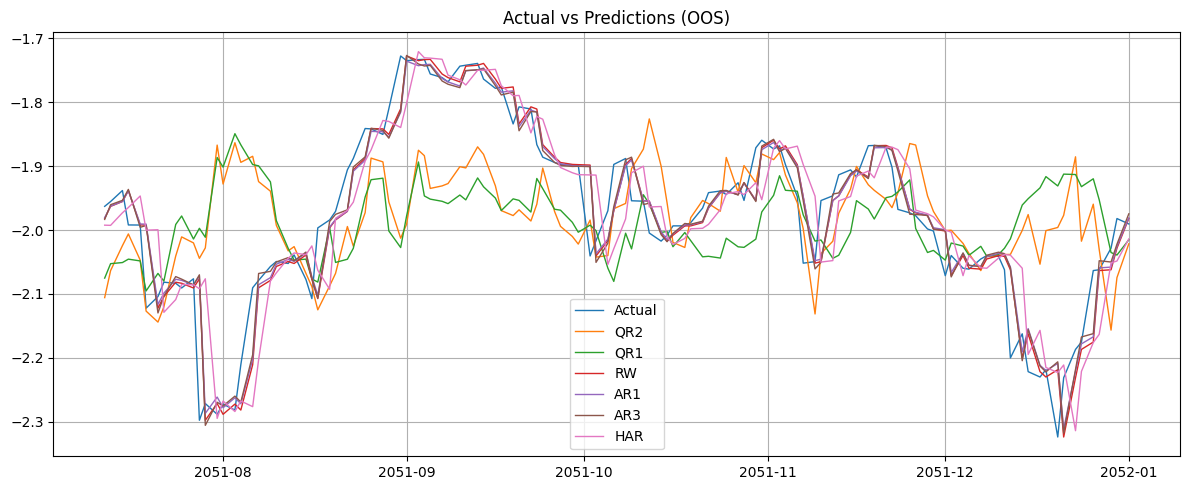

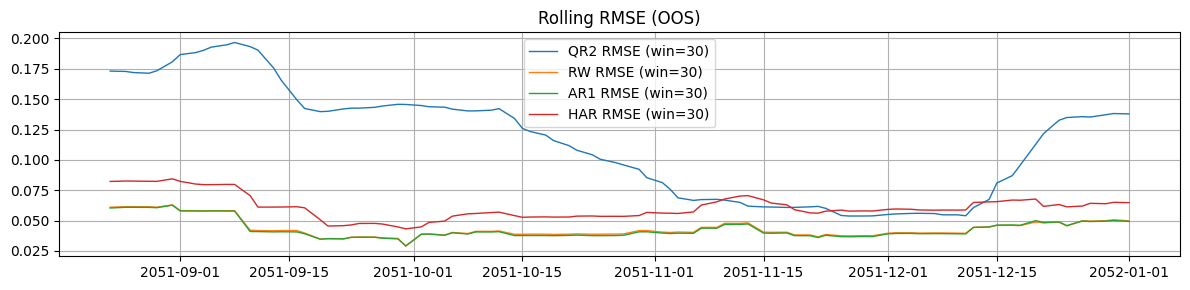

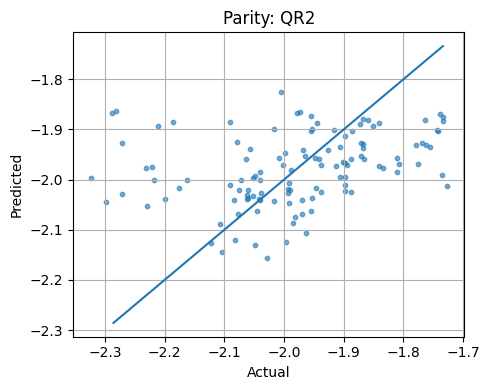

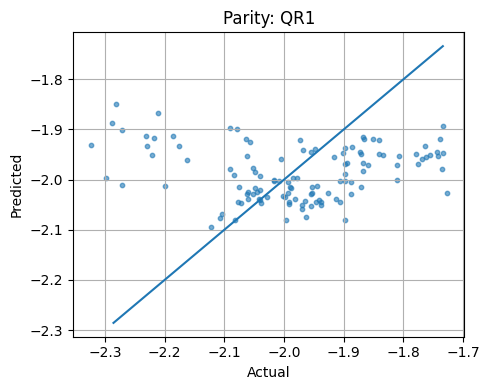

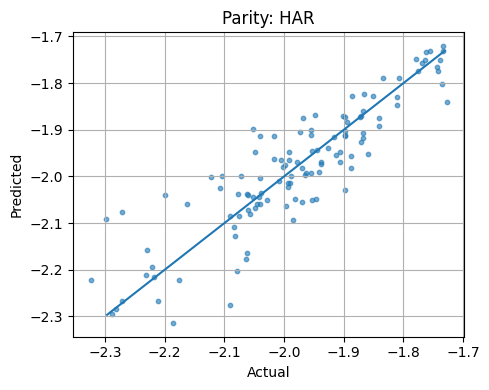


=== 相対RMSE（RW基準）===
QR2: RMSE=0.135292  RMSE/RW=2.795
QR1: RMSE=0.149897  RMSE/RW=3.097
 RW: RMSE=0.048403  RMSE/RW=1.000
AR1: RMSE=0.047880  RMSE/RW=0.989
AR3: RMSE=0.047879  RMSE/RW=0.989
HAR: RMSE=0.065924  RMSE/RW=1.362


In [25]:
# 3. 結果表示群（重ね可視化 / Rolling RMSE / Parity / 定量print 充実）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

art   = TRAINING_ARTIFACTS
task  = art["task"]
dates = art["date_oos"]
y     = art["y_oos"]
res   = art["results"]

print("=== 目的/タスク ===", {"task": task, "target": art["target_label"]})
print("=== 採択特徴 ===", art["sel_cols"])
print("=== コンフィグ ===", art["config"], "\n")

print("=== OOS 指標（MSE/QLIKE ほか）===")
print(art["metrics_df"].to_string(index=False))

if "dm_best_vs_qr2" in art:
    d = art["dm_best_vs_qr2"]
    print(f"\n=== DM（QR2 vs {d['best_base']}）: stat={d['DM-stat']:.3f}, p={d['p']:.3e}")

print("\n=== MCS(MSE) survivors ===", art["mcs_mse"])

# ---- (1) Actual + 予測（重ね書き）----
plt.figure(figsize=(12,5))
plt.plot(dates, y, label="Actual", linewidth=1)
for name in ["QR2","QR1","RW","AR1","AR3","HAR"]:
    if name in res:
        plt.plot(dates, res[name], label=name, linewidth=1)
plt.title("Actual vs Predictions (OOS)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---- (2) Rolling RMSE（窓=30）----
w = 30
plt.figure(figsize=(12,3))
for name in ["QR2","RW","AR1","HAR"]:
    if name in res:
        rm = pd.Series((y - res[name])**2, index=dates).rolling(w).mean().pow(0.5)
        plt.plot(rm.index, rm.values, label=f"{name} RMSE (win={w})", linewidth=1)
plt.title("Rolling RMSE (OOS)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---- (3) Parity（Actual vs 予測）— 1枚ずつ（サブプロット不使用）----
for name in ["QR2","QR1","HAR"]:
    if name not in res: 
        continue
    plt.figure(figsize=(5,4))
    ok = np.isfinite(y) & np.isfinite(res[name])
    plt.scatter(y[ok], res[name][ok], s=10, alpha=0.6)
    lo, hi = np.nanpercentile(np.r_[y[ok], res[name][ok]], [1,99])
    plt.plot([lo,hi], [lo,hi])
    plt.title(f"Parity: {name}")
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.grid(True); plt.tight_layout(); plt.show()

# ---- (4) 相対RMSE（RW基準）----
rw_rmse = float(np.sqrt(np.mean((y - res["RW"])**2))) if "RW" in res else np.nan
print("\n=== 相対RMSE（RW基準）===")
for name in res.keys():
    r = float(np.sqrt(np.mean((y - res[name])**2)))
    ratio = r/rw_rmse if np.isfinite(rw_rmse) and rw_rmse>0 else np.nan
    print(f"{name:>3}: RMSE={r:.6f}  RMSE/RW={ratio:.3f}")
